# Guruprasad Velikadu Krishnamoorthy
# DSC530- Assignment Week 8

## Initial Setup

In [1]:
# Download basename and exists from OS module which will be used in the download function
from os.path import basename, exists

# Create a function named download_file, to dounload the scripts and files from Github to local path
def download_files(url):
    """
    Downloads the scripts/ files from Github to local directory
    takes url as input.
    """
    filename = basename(url)
    # Checking if the file exists in the local directory and it downloads the file if it doesn't exist already.
    if not exists(filename):
        from urllib.request import urlretrieve
        # Downloading the files to the local path
        local, _ = urlretrieve(url, filename)
        # Printing confirmation message
        print("Downloaded " + local)

In [2]:
#  Calling download functions to download .py files and data files used throughtout this assignment
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [3]:
# Importing the nsfg and other modules module from the author's code
import nsfg
import thinkstats2
import thinkplot

# importing the required libraries
import numpy as np
import sys
from collections import defaultdict
import math
import itertools
import pandas as pd
import scipy.stats as sci
import random
import matplotlib.pyplot as plt
import first
import brfss

# Exercise 9.1

#### ***Question:*** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

#### To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

#### What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

##### ***Solution:*** To approach the problem, we first create classes  for different type of hypothesis test such as Tests using difference in means, Hypothesis testing using Correlation, chi-squared test.

In [4]:
# Below is the HypothesisTest Class based on thinkstats2 module
class HypothesisTest_base(object):
    """
    An abstract lass that conducts Hypothesis test. Code is referenced from thinkstats2.
    """
    # This is the initial setup. whenever the class is invoked, this part will execute
    def __init__(self, input_data):
        self.input_data = input_data
        # Performs initial processing setup such as deriving array lengths., etc and builds a representation
        # of Null hypothesis.
        self.CreateModel()
        # Deriving actual value. This will be used for comparison while running hypothesis tests.
        self.actual_value = self.CreateTestStatistic(input_data)
        

    # This method computes the final PValue. 
    def calculate_PValue(self, iterations=1000):
        # This loops through the number of iterations and calls ExecuteModel module and collects results in a list
        self.model_outputs = [self.CreateTestStatistic(self.ExecuteModel()) for _ in range(iterations)]
        # This compares the actual value with each value in the test_stats list. If the test_stats value is greate
        # the result will be captured in the count variable.
        #print(self.actual_value)
        eligible_count = sum(1 for model_output in self.model_outputs if model_output >= self.actual_value)
        # The ratio of count to number of iterations is the P-Value
        #print(eligible_count / iterations)
        return eligible_count / iterations

    # Placeholder method for CreateTestStatistic. Raises exception if not defined
    def CreateTestStatistic(self, input_data):
        raise UnimplementedMethodException()

    # Placeholder method for MakeModel. 
    def CreateModel(self):
        pass
    
    # Placeholder method for RunModel. Raises exception if not defined
    def ExecuteModel(self):
        raise UnimplementedMethodException()

In [5]:
class HypothesisTest_Means(HypothesisTest_base):
    """
    This class is derived from HypothesisTest. The method used is by finding the difference between the 
    means of the two groups of input data. By simulating the test with various data samples, we can calculate
    the number of times the difference in the mean between the groups exceeds the original difference.
    If the difference is lesser than 5%, we reject the Null hypothesis and the result is 
    statistically significant.
    """
    # This computes the size of the effect in the sample.
    def CreateTestStatistic(self, input_data):
        # Split the input that has 2 groups and assign to variables
        input_data_1, input_data_2 = input_data
        # find the absolute value of difference between mean of two groups
        derived_test_stats = abs(input_data_1.mean() - input_data_2.mean())
        #print(f"derived_test_stats is {derived_test_stats}")
        return derived_test_stats

    # Creates a Model that will be used further in the Testing
    def CreateModel(self):
        # Split the input that has 2 groups and assign to variables
        input_data_1, input_data_2 = self.input_data
        # Compute the length of each group
        self.input_data_1_size, self.input_data_2_size = len(input_data_1), len(input_data_2)
        # Combine the data from both groups and create a single array 
        self.combined_datapool = np.hstack((input_data_1, input_data_2 ))

    # this will run the Model through multiple iterations and generate results for each run
    def ExecuteModel(self):
        # Shuffle the data in combined dataset
        np.random.shuffle(self.combined_datapool)
        # create sample data from combined pool with same dimensions as the original data.
        # We create 2 groups with lengths of input_data_1_size and input_data_2_size
        input_data = self.combined_datapool[:self.input_data_1_size], self.combined_datapool[self.input_data_1_size:]
        return input_data

In [6]:
class HypothesisTest_ChiSquared(HypothesisTest_base):
    """
    This class is also derived from HypothesisTest. The method used is by finding the chi squared value. 
    The Chi-squared statistic is calculated as the sum of squares of each observation from the expected
    value divided by the expected value. By simulating the test with various data samples, we can calculate
    the chi-squared of the samples exceeds the original chi-squared statistics and calculate the count.
    If the count is lesser than 5%, we reject the Null hypothesis and the result is 
    statistically significant.
    """
    # Creates a Model that will be used further in the Testing
    def CreateModel(self):
        # The input data has 2groups first babies and other babies
        first_babies, other_babies = self.input_data
        # Computing the number of elements in first babies array
        self.first_babies_count = len(first_babies)
        # Combining the two arrays
        self.combined_data = np.hstack((first_babies, other_babies ))
        # Creating a Prob Mass function of the combined data
        pmf_model = thinkstats2.Pmf(self.combined_data)
        # Restricting the chi-squared test only for the age range between 35 to 43 to exclude outliers
        self.age_range = range(35, 44)
        # Calculating expected probablity from pmf created above for each value of age between 35 to 43.
        self.expected_probs = np.array(pmf_model.Probs(self.age_range))

    # This will run the Model through multiple iterations and generate results for each run    
    def ExecuteModel(self):
        # shuffling the combined data
        np.random.shuffle(self.combined_data)
        # creating new dataset of same dimensions as original from the shuffled data
        model_data = self.combined_data[:self.first_babies_count], self.combined_data[self.first_babies_count:]
        return model_data
    
    # Compute the Chi squared statistic of the input series
    def CreateTestStatistic(self, input_data):
        # The input data has 2groups first babies and other babies
        first_babies, other_babies = input_data
        # Call the Chi Squared function for both first and other babies and compute the sum
        derived_test_stats = self.ChiSquared(first_babies) + self.ChiSquared(other_babies)
        return derived_test_stats

    # Function to compute the ChiSquared Statistic which is the sum of squares of each observation 
    # from the expected value divided by the expected value
    def ChiSquared(self, input_series):
        # Creating an histogram for the input series
        histogram_1 = thinkstats2.Hist(input_series)
        # Calculate the observed Frequency from the histogram for the age range from 35 to 43
        observed_freq = np.array(histogram_1.Freqs(self.age_range))
        # Calculate the expected frequency from expected probablity calculated above
        expected_freq = self.expected_probs * len(input_series)
        # Calculating the Chi squared stat using the formula mentioned in the comments
        ChiSquared_Stat = sum((observed_freq - expected_freq)**2 / expected_freq)
        return ChiSquared_Stat

In [7]:
class HypothesisTest_Correlation(HypothesisTest_base):
    """
    This class is derived from HypothesisTest. The method used is by finding the correlation between two groups of input data.
    By simulating the test with various data samples, we can calculate the number of times the correlation between the groups exceeds 
    the original corelation. If the count is lesser than 5%, we reject the Null hypothesis and the result is 
    statistically significant.
    """
    # This computes the size of the effect in the sample.
    def CreateTestStatistic(self, input_data):
         # Split the input that has 2 groups and assign to variables
        input_data_1, input_data_2 = input_data
        # find the absolute value of correlation between two groups
        derived_test_stats = abs(thinkstats2.Corr(input_data_1, input_data_2))
        return derived_test_stats

    def ExecuteModel(self):
        # Split the input that has 2 groups and assign to variables
        data_1,data_2 = self.input_data
        # Shuffle the first series and return the series to find the correlation between the shuffled data
        data_1 = np.random.permutation(data_1)
        return data_1,data_2

In [8]:
def Run_Hypothesis_Tests(dataset, iterations=1000):
    """
    Executes the different types of Hypothesis tests for the given data samples.
    dataset: Input dataframe with different lengths
    iterations: number of iterations to run
    """
    # Calculate the size of the dataframe
    dataset_len = len(dataset)
    print(f"The Dataset length is {dataset_len}")
    # Define the datasets for First and other babies
    firsts = dataset[dataset.birthord == 1]
    others = dataset[dataset.birthord != 1]
    # Hypothesis Tests of Pregnancy lengths using means method
    input_data = firsts.prglngth.values, others.prglngth.values
    ht1_means = HypothesisTest_Means(input_data)
    PValue1_means = ht1_means.calculate_PValue(iterations=1000)
    print(f"PValue1_means is {PValue1_means}")
    # Hypothesis Tests of Total baby Weight using means method
    input_data2 = (firsts.totalwgt_lb.dropna().values,others.totalwgt_lb.dropna().values)
    ht2_means = HypothesisTest_Means(input_data2)
    PValue2_means = ht2_means.calculate_PValue(iterations=1000)
    print(f"PValue2_means is {PValue2_means} ")
    # Hypothesis Tests using Correlation method
    refined_dataset = dataset.dropna(subset=['agepreg', 'totalwgt_lb'])
    input_data3 = refined_dataset.agepreg.values, refined_dataset.totalwgt_lb.values
    ht3_corr = HypothesisTest_Correlation(input_data3)
    PValue3_corr = ht3_corr.calculate_PValue(iterations=1000)
    print(f"PValue3_corr is {PValue3_corr} ")
    # Hypothesis Tests using Chi-squared statistic
    input_data4 = firsts.prglngth.values, others.prglngth.values
    ht4_chi = HypothesisTest_ChiSquared(input_data4)
    PValue4_chi = ht4_chi.calculate_PValue(iterations=1000)
    print(f"PValue4_chi is {PValue4_chi} ")
    print("***************************************")
    

In [9]:
# Creating live dataframe which will be used for the hypothesis testing
live, firsts, others = first.MakeFrames()


In [10]:
# Calculating the length of the live dataframe
dataset_len=len(live)
# Creating an array of numbers from 0 to 40
lengths=np.arange(1,41)
# creating sample sizes from the live dataset
sample_lengths=[round(dataset_len/length) for length in lengths]
#loop through each sample size and create sample data using SampleRows
for sample_len in sample_lengths:
    sample_dataset = thinkstats2.SampleRows(live, sample_len)
    # Running the Hypothesis test for each sample size 
    Run_Hypothesis_Tests(sample_dataset)


The Dataset length is 9148
PValue1_means is 0.169
PValue2_means is 0.0 
PValue3_corr is 0.0 
PValue4_chi is 0.0 
***************************************
The Dataset length is 4574
PValue1_means is 0.199
PValue2_means is 0.002 
PValue3_corr is 0.0 
PValue4_chi is 0.0 
***************************************
The Dataset length is 3049
PValue1_means is 0.225
PValue2_means is 0.029 
PValue3_corr is 0.0 
PValue4_chi is 0.0 
***************************************
The Dataset length is 2287
PValue1_means is 0.604
PValue2_means is 0.076 
PValue3_corr is 0.0 
PValue4_chi is 0.0 
***************************************
The Dataset length is 1830
PValue1_means is 0.48
PValue2_means is 0.0 
PValue3_corr is 0.001 
PValue4_chi is 0.0 
***************************************
The Dataset length is 1525
PValue1_means is 0.327
PValue2_means is 0.003 
PValue3_corr is 0.001 
PValue4_chi is 0.0 
***************************************
The Dataset length is 1307
PValue1_means is 0.191
PValue2_means is 0.08

#### The results indicate that the P values return variable results for different values of sample sizes, so the distribution is uneven. Even smaller sample sizes returns positive P values. We conducted this experiment with 40 sample sizes and the smallest of it which is 229, also returns positive p values. These results can vary based on the sample sizes we pick. 

# Exercise 10.1

#### ***Question:*** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

#### Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

#### ***Solution***: To answer the first part of the question, we calculate the slopes and intercepts of the Linear regression. Then take Natural log10 of the weights sequence and calculate the slope and intercept. The results are then plotted using scatter plot. To analyse the prediction power of weight from height, we calculate the residuals, and then from the variance of residuals and the weight, we can determine the Coefficient of determination(R^2). This is a better indicator of reduction in Root Mean square Error. The reduction in RMSE is a better indicator of Prediction behavior.

In [11]:
# Creating the brfss dataframe using the brfss module
df_brfss = brfss.ReadBrfss(nrows=None)
# The two variables that we are intersted are weight and the heights. so excluding nulls from these.
df_brfss = df_brfss.dropna(subset=['htm3', 'wtkg2'])
# Assigning names for these variables for ease of usage.
heights_brfss, weights_brfss = df_brfss.htm3, df_brfss.wtkg2
# Taking natural log10 for weights variable
log_weights_brfss = np.log10(weights_brfss)

In [12]:
# In this section we define the methods used.
from thinkstats2 import Mean, MeanVar, Var, Std
# The Covariance is a measure of tendency of two variables to vary together.
def Cov(xs, ys, meanx=None, meany=None):
    """
    Takes two variables as arrays as input. Means of these variables are optional.
    Returns the covariance between the two variables.
    """
    # Converting the inputs into arrays
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    # If mean is not provided, it will be calculated.
    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)
    # Covariance is measured as the sum of product of deviations from mean of each variable divided by the number of items in first .
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

# Least Squares method calculates the slope of the linear relationship
def Least_Squares(xs_array, ys_array):
    """
    Takes two input sequences for which the slope and intercept to be calculated.
    Returns slope and intercept.
    """
    # Calculating the Mean and variance of the sequences
    mean_xs, var_xs = MeanVar(xs_array)
    mean_ys = Mean(ys_array)
    # Calculating the slope by diving the Covariance of two variables/ variance of x
    slope = Cov(xs_array, ys_array, mean_xs, mean_ys) / var_xs
    # Intercept is calculated from formula ys = Intercept + (xs*slope)
    intercept = mean_ys - slope * mean_xs
    return intercept, slope

# This will calculate the x and y coordinates to fit a line on a plot
def FitLine(xs, inter, slope):
    """
    The function takes sequence x, slope and intercept and returns the Sequence y along with x.
    """
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

def ResampleRows(df):
    """Resamples rows from a DataFrame.
    df: DataFrame
    returns: DataFrame
    """
    return thinkstats2.SampleRows(df, len(df), replace=True)

In [13]:
# Calculating the Intercept and slope of heights and weights variables
intercept_hw, slope_hw = Least_Squares(heights_brfss, weights_brfss)
print(f" The intercept and Slope of heights and weights of brfss dataset is {intercept_hw} , {slope_hw}")# Calculating the Intercept and slope of heights and log10 of weights variables
# Calculating the Intercept and slope of heights and log10 of weights variables
intercept_hw_log, slope_hw_log = Least_Squares(heights_brfss, log_weights_brfss)
print(f" The intercept and Slope of heights and log 10 of weights of brfss dataset is {intercept_hw_log} , {slope_hw_log}")


 The intercept and Slope of heights and weights of brfss dataset is -82.65926054408709 , 0.9570745850332383
 The intercept and Slope of heights and log 10 of weights of brfss dataset is 0.9930804163918064 , 0.005281454169417842


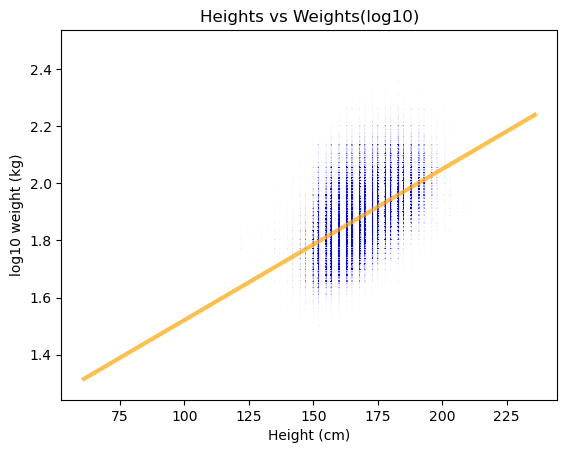

In [14]:
# Using scatter plot to show the Heights and natural log10 value of Weights 
thinkplot.Scatter(heights_brfss, log_weights_brfss, alpha=0.01,s=1)
# using fitline function to compute x and y co-ordinates for the linear relation
fxs_array1, fys_array1 = FitLine(heights_brfss, intercept_hw_log, slope_hw_log)
# Plotting the line
thinkplot.Plot(fxs_array1, fys_array1, color='orange')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False,
                title="Heights vs Weights(log10)")
# The plot indicates a linear relationship between the Heights and weights raised to the power of log10

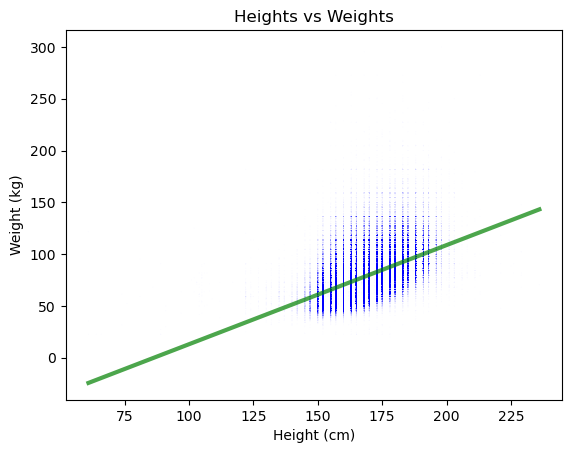

In [15]:
# Using scatter plot to show the Heights and Weights 
thinkplot.Scatter(heights_brfss, weights_brfss, alpha=0.01, s=1)
# using fitline function to compute x and y co-ordinates for the linear relation
fxs_array2, fys_array2 = FitLine(heights_brfss, intercept_hw, slope_hw)
# Plotting the fitted line
thinkplot.Plot(fxs_array2, fys_array2, color='green')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False,title="Heights vs Weights")
# This plot also indicates a linear relation(but with a different slope and intercept) between heights and weights.

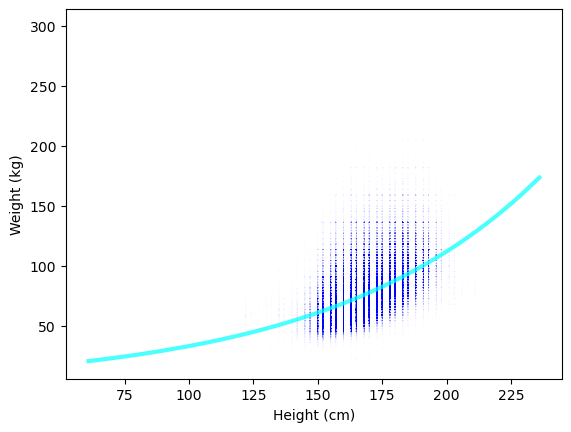

In [16]:
# Using scatter plot to show the Heights and Weights 
thinkplot.Scatter(heights_brfss, weights_brfss, alpha=0.01, s=1)
fxs_array3, fys_array3 = FitLine(heights_brfss, intercept_hw_log, slope_hw_log)
thinkplot.Plot(fxs_array3, 10**fys_array3, color='aqua')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)
# In this plotthe weights are represented in a linear scale using the slope and intercept calculated from log10 of weights.
# Results indicate the line is not a linear relation.

In [17]:
# Calculating residuals using the formula res=ys-(intercept+slope*xs)
def Calculate_Residuals(xs_array, ys_array, intercept, slope):
    """
    Inputs are two sequences x and y and their intercept and slope.
    Returns the residuals which is the difference between actual values and fitted line.
    """
    xs_array = np.asarray(xs_array)
    ys_array = np.asarray(ys_array)
    residuals = ys_array - (intercept + slope * xs_array)
    return residuals

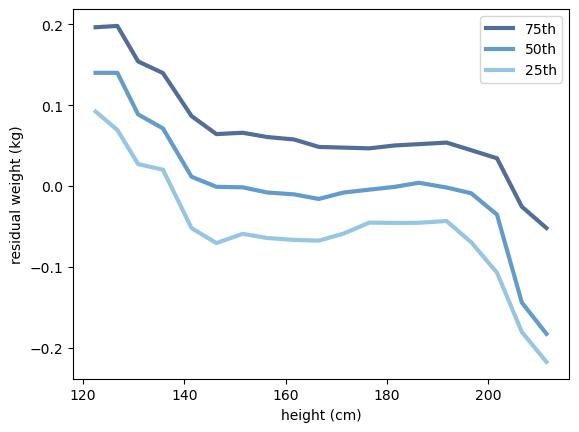

In [18]:
# Residuals of the brfss heights and log10 of weights are calculated
residuals = Calculate_Residuals(heights_brfss, log_weights_brfss, intercept_hw_log, slope_hw_log)
# Adding a new field residual to the dataframe
df_brfss['residual'] = residuals
# To calulate the cdf we create bins of the heights sequence
height_bins = np.arange(120, 220, 5)
# this will assign the heights to the individual bin
height_indices = np.digitize(df_brfss.htm3, height_bins)
# creating groups based on the bins assigned.
height_groups = df_brfss.groupby(height_indices)
# In this section we create the x and y variables to plot the percentile plot. The x varaible will be the mean of 
# each group. The y variable will be the percentile value  of residuals that will be calculated from cdf plot
height_means = [height_group1.htm3.mean() for indx1, height_group1 in height_groups][1:-1]
height_cdfs = [thinkstats2.Cdf(height_group2.residual) for indx2, height_group2 in height_groups][1:-1]
thinkplot.PrePlot(3)
#creating plots for each value of mean height of each bin vs Residual Percentile 
for percent in [75, 50, 25]:
    residual_percentile = [height_cdf.Percentile(percent) for height_cdf in height_cdfs]
    label = '%dth' % percent
    thinkplot.Plot(height_means, residual_percentile, label=label)
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=True)

#### The Percentile plot shows similar distribution of residuals for each percentile range. For example, residual is between 0.2 and 0.1 (log10 values) for the height of 126 cms. The interquantile range is 0.4 (log10 values). So if we know the heights, we can calculate the log10 value of height within a range of 0.2 most of the time.

In [19]:
# Coefficient of determination is a measure of goodness of fit of linear model 
# and is denoted as R-squared
def CoefDetermination(ys, res):
    """
    inputs are ys sequence and the residuals. 
    Returns the Coefficient of Determination value
    """
    return 1 - Var(res) / Var(ys)

# Calculating Pearson correlation between Heights and log10 of Weights
rho_correlation = thinkstats2.Corr(heights_brfss, log_weights_brfss)
CoefDetermination_1 = thinkstats2.CoefDetermination(log_weights_brfss, residuals)
# Comparing the suare of Correlation and the Coefficient of determintion. Both are almost same
rho_correlation,CoefDetermination_1,rho_correlation**2

(0.5317282605983464, 0.2827349431189352, 0.28273494311894304)

In [20]:
#Compute Std(ys), which is the RMSE of predictions that don't use height.
std_weights = thinkstats2.Std(log_weights_brfss)
print(f"The Standard Deviation of log10 of weights is {std_weights} ")

# Compute Std(res), the RMSE of predictions that do use height.
std_residuals = thinkstats2.Std(residuals)
print(f"The Standard Deviation of residuals is {std_residuals} ")

# How much does height information reduce RMSE?
print(1-std_residuals / std_weights)

The Standard Deviation of log10 of weights is 0.10320725030004853 
The Standard Deviation of residuals is 0.08740777080416083 
0.1530849765879313


#### The reduction in Root Mean square error is a better indicator of prediction power. So using Heights to predict the weights reduces the Root mean square error from 0.103207 to 0.0874077 points, which is a 15.3 % reduction in the Root mean square error.

In [21]:
# Use Sampling Distribution to create samples by calling Resample method
def Create_SamplingDist(dataset, iterations=101):
    """
    Input is a dataframe for which samples to be created.
    Creates different samples and returns intersect and slope of the samples.
    """
    # create a list to store the samples.
    samples=[]
    # Loop through each iteration and create samples.
    for iterat in range(iterations):
        # Uses replace=True in ResampleRows function to include same rows again in the sample
        sample_df=ResampleRows(dataset)
        # Use LeastSquares method to calculate the intersect and slope of the samples.
        sample = Least_Squares(sample_df.htm3, np.log10(sample_df.wtkg2))
        samples.append(sample)
    # Zip function is used to unpack the intersect and Slope of each samples.
    intersect_sample, slope_sample = zip(*samples)
    return intersect_sample,slope_sample


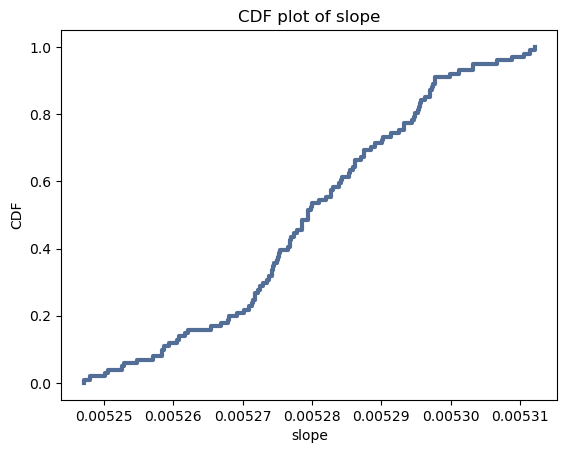

In [22]:
# Use the Create_SamplingDist on brfss dataframe and calculate the intersects and slopes arrays.
intersect_samples,slope_samples=Create_SamplingDist(df_brfss)
# Calculate the CDF of slopes and plot the CDF
cdf_slope=thinkstats2.Cdf(slope_samples)
thinkplot.Cdf(cdf_slope)
thinkplot.Config(xlabel='slope', ylabel='CDF', title="CDF plot of slope")

In [23]:
# Calculating the Confidence interval of 90
conf_interval_slope = cdf_slope.Percentile(5), cdf_slope.Percentile(95)
conf_interval_slope

(0.005252854631109656, 0.005303215599520881)

In [24]:
# Calculating the mean of the slopes array created above
mean_slope = thinkstats2.Mean(slope_samples)
mean_slope

0.005280241107556398

In [25]:
# Calculating the Standard Deviation of the slopes array created above
stderr_slope = thinkstats2.Std(slope_samples)
stderr_slope

1.5103320066442336e-05

In [26]:
def Summarize(array1, actual=None):
    """
    Returns the summary of mean, standard deviation, cdf and the Confidence interval of the input sequence.
    """
    mean = Mean(array1)
    stderr = Std(array1, mu=actual)
    cdf = thinkstats2.Cdf(array1)
    ci = cdf.ConfidenceInterval(90)
    print(f'The Mean, Standard Error  and Confidence Interval are {mean}, {stderr} and {ci} respectively ' )

In [27]:
# Creating samples without weights and using ResampleRows function with replace=True
# This creates the mean of heights from each unweighted sample which is run for 100 iterations
estimates_unweighted = [thinkstats2.ResampleRows(df_brfss).htm3.mean() for iterat in range(101)]
# the results are stored in the list and the summary of mean, std deviation and Confidence interval are  summarized.
Summarize(estimates_unweighted)

The Mean, Standard Error  and Confidence Interval are 168.95689482926952, 0.01601363263451798 and (168.92623890943634, 168.97899108712787) respectively 


In [28]:
def ResampleRowsWeighted(df, column="finalwgt"):
    """Resamples a DataFrame using probabilities proportional to given column.
    df: DataFrame
    column: string column name to use as weights
    returns: DataFrame
    """
    # Creating a CDF of the weights variable by calculating the distribution
    weights = df[column].copy()
    weights /= sum(weights)
    # creating an indices array that contains the sequence of Rows
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    # Creating a weighted sample based on the row index
    sample = df.loc[indices]
    return sample

In [29]:
# Creating samples WITH weights and using ResampleRowsWeighted function with replace=True
# This creates the mean of the variable finalwt from each weighed sample which is run for 100 iterations
estimates_weighted = [ResampleRowsWeighted(df_brfss, 'finalwt').htm3.mean() for _ in range(101)]
# the results are stored in the list and the summary of mean, std deviation and Confidence interval are  summarized.
Summarize(estimates_weighted)

The Mean, Standard Error  and Confidence Interval are 170.49892100939314, 0.016651492056531603 and (170.4738677014491, 170.5296262050567) respectively 


#### The results of weighed and unweighed function indicates a difference of about 2 cm in the mean heights( 170.49 cm and 168.95 cm). Also this difference is higher than the standard error. 